### Import packages

In [1]:
library(data.table)
library(Matrix)
library(proxy)
library(Rtsne)
library(densityClust)
library(data.table)
library(irlba)
library(umap)
library(ggplot2)
library(RColorBrewer)


Attaching package: ‘proxy’

The following object is masked from ‘package:Matrix’:

    as.matrix

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix



### Load Data

In [2]:
load('Cusanovich2018_buenrostro2018.RData')

### Following tutorial at https://shendurelab.github.io/fly-atac/docs/#usecase2

In [3]:
#desired number of clusters
nClusters = length(levels(as.factor(metadata$label)))
nClusters

[1] 10

In [4]:
#To identify clusters of cells, we use the density peak algorithm.

tsnedist = dist(tsnetfidf$Y)
set.seed(0)
dclust = densityClust(tsnedist,gaussian=T)
dclust = findClusters(dclust, rho = 20, delta = 9)


Distance cutoff calculated to 2.085785 


In [5]:
#number of clusters produced
nClusters_produced = length(levels(as.factor(dclust$clusters)))
nClusters_produced
levels(as.factor(dclust$clusters))

[1] 10

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10"

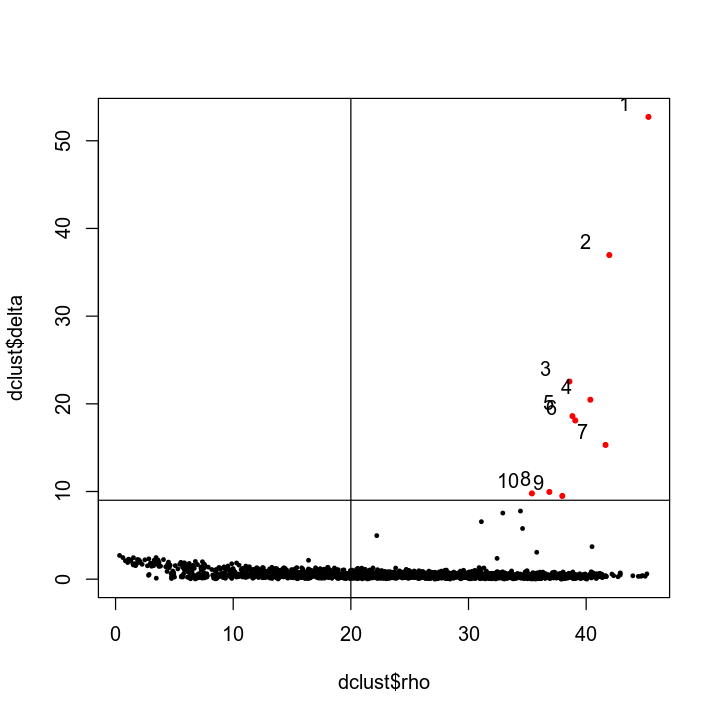

In [6]:
#plot from tutorial
#The density peak algorithm requires you to set two parameters - “delta” and “rho”. For each data point, the algorithm calculates a local density of other points within some set distance and the minimum distance to the next point that has a higher local density. On the basis of these two values, you can choose a set of points that are outliers both in local density and the distance to another point with a higher density, which become cluster “peaks”. Below, we show you the distribution of these two values in our data set and where we decided to draw the cutoff. You can read more about this algorithm here.

options(repr.plot.width=6, repr.plot.height=6)
plot(dclust$rho,dclust$delta,pch=20,cex=0.6)
points(dclust$rho[dclust$peaks],dclust$delta[dclust$peaks],col="red",pch=20,cex=0.8)
text(dclust$rho[dclust$peaks]-2,dclust$delta[dclust$peaks]+1.5,labels=dclust$clusters[dclust$peaks])
abline(v=20)
abline(h=9)

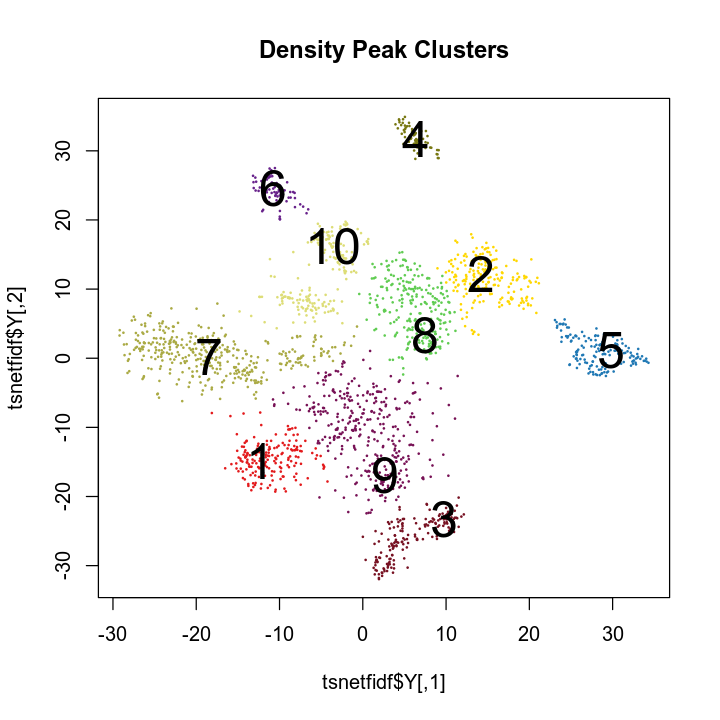

In [7]:
#plot from tutorial
tsnecols = c("#E31A1C","#FFD700","#771122","#777711","#1F78B4","#68228B","#AAAA44",
                 "#60CC52","#771155","#DDDD77","#774411","#AA7744","#AA4455","#117744",
                 "#000080","#44AA77","#AA4488","#DDAA77")
plot(tsnetfidf$Y,pch=20,col=tsnecols[as.factor(dclust$clusters)],main="Density Peak Clusters",cex=0.25)
text(tsnetfidf$Y[dclust$peaks,1],tsnetfidf$Y[dclust$peaks,2],labels=dclust$clusters[dclust$peaks],cex=2.5)

In [8]:
str(tsnetfidf)

List of 14
 $ N                  : int 2034
 $ Y                  : num [1:2034, 1:2] -11.21 -12.87 -12.8 -13.18 -8.67 ...
 $ costs              : num [1:2034] 7.34e-05 1.73e-04 2.22e-04 3.58e-04 2.91e-04 ...
 $ itercosts          : num [1:20] 73.7 68.1 67.9 67.9 67.9 ...
 $ origD              : int 150
 $ perplexity         : num 30
 $ theta              : num 0.5
 $ max_iter           : num 1000
 $ stop_lying_iter    : int 250
 $ mom_switch_iter    : int 250
 $ momentum           : num 0.5
 $ final_momentum     : num 0.8
 $ eta                : num 200
 $ exaggeration_factor: num 12


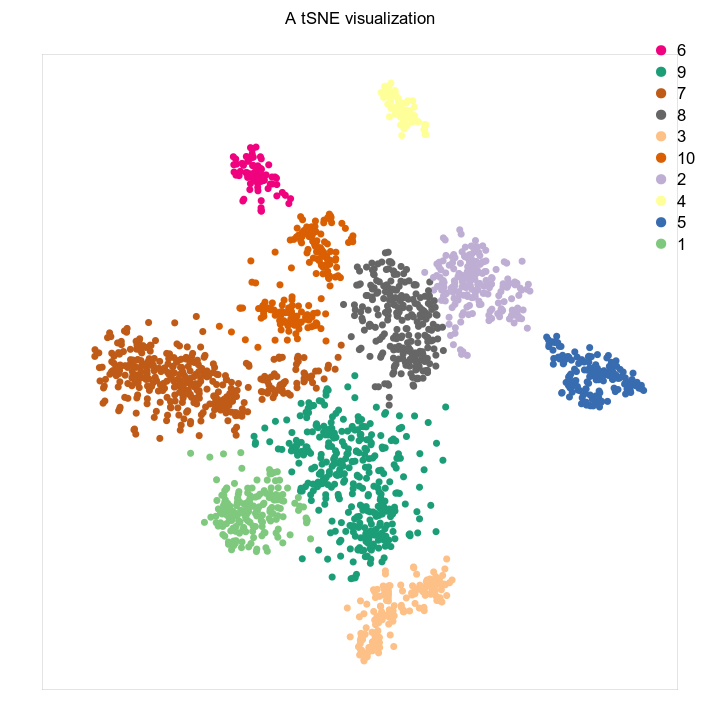

In [9]:
plot.tsne(tsnetfidf$Y,as.factor(dclust$clusters))

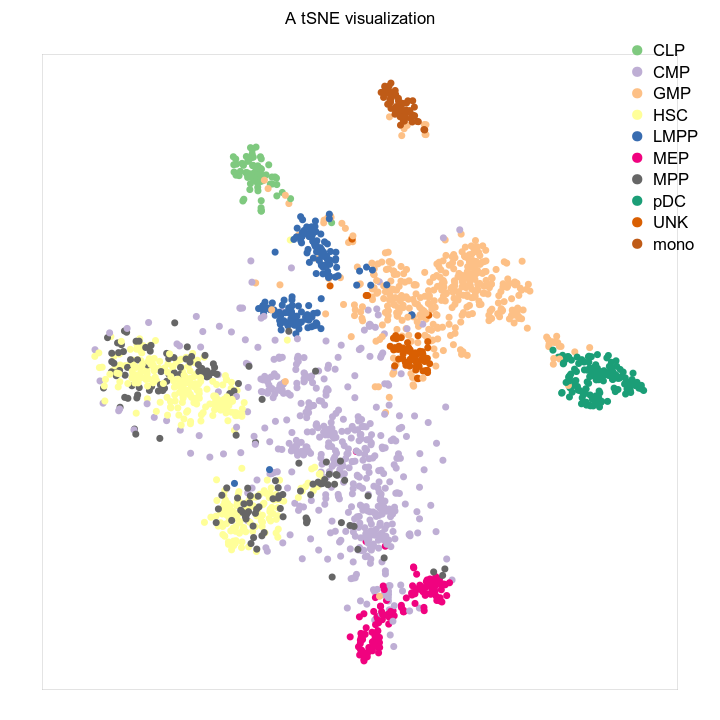

In [10]:
plot.tsne(tsnetfidf$Y,as.factor(metadata[,'label']))

In [11]:
## results from pca and tsne reduction types are the same...

#result = data.frame("cusanovich2018.tsne" = seurat_obj.tsne_clustering@ident)
#result2 = data.frame("cusanovich2018.pca" = seurat_obj@ident)
#m = merge(result,result2,by='row.names')

df_out = data.frame("cusanovich2018" = dclust$clusters)
rownames(df_out) = rownames(metadata)
write.table(df_out,file="clusteringSolution.tsv", quote=FALSE, sep='\t', col.names = NA)

In [13]:
head(df_out)

,cusanovich2018
BM1077-CLP-Frozen-160106-13,6
BM1077-CLP-Frozen-160106-14,6
BM1077-CLP-Frozen-160106-2,6
BM1077-CLP-Frozen-160106-21,6
BM1077-CLP-Frozen-160106-27,6
BM1077-CLP-Frozen-160106-3,6
